In [1]:
import PIL
import math
import PIL.Image
import os
import matplotlib.pyplot as plt
from tensorflow import keras
from sklearn.model_selection import train_test_split
import numpy as np

# Preprocessing

## Convert CMYK Image into RGB
source : https://www.ginifab.com/feeds/pms/cmyk_to_rgb.php

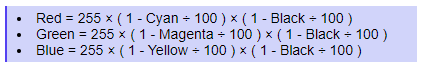


In [2]:
def cmyk2rgb(image_array):
    rgb_image_array = np.zeros((image_array.shape[0], image_array.shape[1], 3), dtype= np.uint8)
    
    rgb_image_array[:,:,0] = 255* (1-image_array[:,:,0]/100)*(1-image_array[:,:,3])
    rgb_image_array[:,:,1] = 255 * (1-image_array[:,:,1]/100)*(1-image_array[:,:,3])
    rgb_image_array[:,:,2] = 255 * (1-image_array[:,:,2]/100)*(1-image_array[:,:,3])

    return rgb_image_array

## Convert Grayscale Image into RGB
source : <br>
https://stackoverflow.com/questions/835753/convert-grayscale-value-to-rgb-representation#:~:text=Conversion%20of%20a%20grayscale%20to,RGB)%20is%20an%20additive%20system. <br>

In [3]:
def grey2rgb(image_array):
    rgb_image_array = np.zeros((image_array.shape[0], image_array.shape[1], 3), dtype= np.uint8)
    rgb_image_array[:,:,0] = image_array
    rgb_image_array[:,:,1] = image_array
    rgb_image_array[:,:,2] = image_array
    
    return rgb_image_array

## Resizing : Lanczos Interpolation
From many interpolation method Lanczos it have good quality on enlarging and shrinking image by PIL library

source : <br>
https://www.youtube.com/watch?v=ijmd6XyG2HA <br>
https://en.wikipedia.org/wiki/Lanczos_resampling <br>
https://pillow.readthedocs.io/en/stable/handbook/concepts.html#PIL.Image.LANCZOS <br>

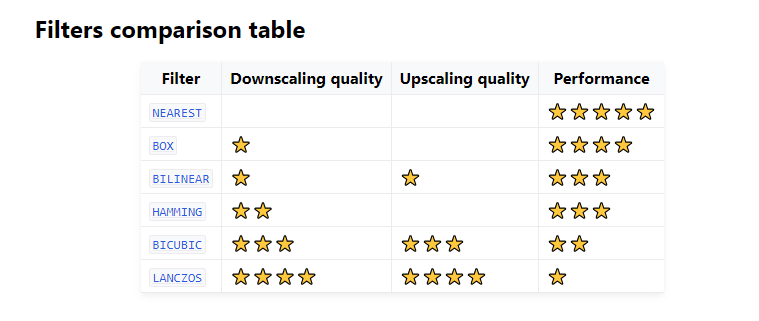

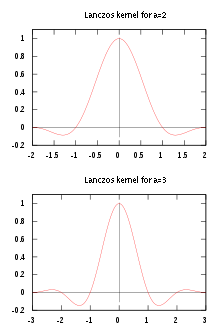

$$ S(x) = \sum^{\lfloor{x}\rfloor+a}_{i =\lfloor{x}\rfloor-a+1}S_{(clamp(x,n-1))}L(x-i) $$

$$ clamp(x,b) = \begin{cases}
          0 & \text{if }  x < 0  \\
          \text{b} & \text{if } x>b \\
          x & \text{otherwise.} 
          \end{cases} $$
          
$$ \text{since if we start start sum with i = -1, and the sample of -1 doesn't exist we neeed to constraint index argument with clamp function} $$   
$$ S(x) = \sum^{\lfloor{x}\rfloor+a}_{i =\lfloor{x}\rfloor-a+1}S_{i}L(x-i) $$


$$ L(x) = \begin{cases} 1 & \text{if }  x = 0 \\
          \frac{a \sin{(\pi x)}\sin{(\frac{\pi x}{a})}}{\pi^{2}x^{2}} & \text{if } -a \le x < a \\
          0 & \text{otherwise.} 
          \end{cases} $$
          
$$ \text{since below equation is not equal because the left pixel we already have but the right need to generate so we need to change the equation into :} $$   
$$ x = -0.5 + \Delta{x}* (n +0.5)$$
$$ \text{to get x coordinate we can use below equation} $$
$$ x = \Delta{x}* n $$
$$ \text{Example, we want resample from 5 pixel into 10 pixel:} $$
$$\Delta{x} = \frac{5}{10} = 0.5 $$
$$ n = \mathcal{E}[0,10) $$

In [4]:
num_classes = 10
input_shape = (28, 28, 1)

# Load the data and split it between train and test sets
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Scale images to the [0, 1] range
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255
# Make sure images have shape (28, 28, 1)
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
print("x_train shape:", x_train.shape)
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")


# convert class vectors to binary class matrices
y_test = keras.utils.to_categorical(y_test, num_classes)
y_train = keras.utils.to_categorical(y_train, num_classes)

11490434/11490434 [==============================] - 0s 0us/step
x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


In [115]:
def resize(image_array, new_height, new_width, lanczos_a = 2):
    
    image_array_height = image_array.shape[0]
    image_array_width = image_array.shape[1]
    image_array_channel = image_array.shape[2]

    resized_image_array = np.zeros((new_height, new_width, image_array_channel), dtype = np.uint8)
    
    
    for c in range(image_array_channel):
        resized_image_array[:, :, c] = lanczos_interpolation(image_array[:, :, c], new_height, new_width, a= lanczos_a)
        

    return resized_image_array

def lanczos_interpolation(image_array, new_height, new_width, a=2):
    old_width = image_array.shape[1]
    old_height = image_array.shape[0]
    
    x_coordinate = generate_new_coordinate(old_width, new_width)
    y_coordinate = generate_new_coordinate(old_height, new_height)
    
    return F(y_coordinate,a,F(x_coordinate, a, image_array).T).T


def generate_new_coordinate(old_size, new_size):
    delta = old_size/ new_size
    j = np.arange(new_size)
    x = -0.5 + delta * (j + 0.5)
    return x

def F(x, a, image_array):
    temp = np.zeros(x.shape)
    
    j = np.floor(x).astype("int")-a+1
    k = np.floor(x).astype("int")+a
    
    i = np.array([np.arange(start, stop+1) for start, stop in zip(j, k)])
    
    x = x - i.T
    lanczos = L(x, a)
    temp = np.sum(lanczos.T * image_array[:,clamp(i, image_array.shape[1]-1)], axis = 2)
    
    return temp

def L(x, a):
    result = np.zeros(x.shape)
    
    mask = (x==0)
    result[mask] = 1
    
    mask = (x!=0) & (x >= -a) & (x<a)
    result[mask] = a*np.sin(np.pi*x[mask])*np.sin(np.pi*x[mask]/a)/ (np.pi**2 * x[mask]**2)
    return result

def clamp(x,b):
    result = x.copy()
    mask = (x<0)
    result[mask] = 1
    
    mask = (x>b)
    result[mask] = b
    
    return result


    

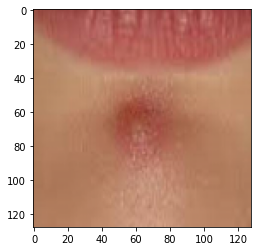

In [116]:
import matplotlib.pyplot as plt
plt.imshow(resize(image_array = np.array(PIL.Image.open("/notebooks/Dataset/skin-90/nodules/n2.JPG")), new_height=128, new_width=128, lanczos_a=3))

## One-Hot Encoding
source : https://en.wikipedia.org/wiki/One-hot


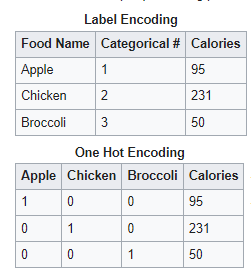


One-Hot needed because we will using Vectorization on the Dense Feed Forward and Back Forward.

In [117]:
def one_hot(Y):
    one_hot_Y = np.zeros((Y.size, Y.max() + 1))
    one_hot_Y[np.arange(Y.size), Y] = 1

    return one_hot_Y

## Transform and Load data 
data needed to transform into structured format

In [118]:
def load_data(directory, image_size=(128, 128)):
    total_image = 0
    label_names_list = [folder for folder in os.listdir(directory)]
    
    #Calculate how many image to make multidimensional Array
    for label_name in label_names_list :
        total_image += len(os.listdir(os.path.join(directory,label_name)))
    
    #Define array of image and target
    stack_of_image = np.zeros((total_image,image_size[0],image_size[1],3), dtype= np.uint8)
    stack_of_label = np.zeros(total_image, int)
    
    temp = total_image
    
    for i, label_name  in enumerate(label_names_list) :
        image_class_path = os.path.join(directory,label_name)
        for image in os.listdir(image_class_path) :
            if not os.path.isfile(os.path.join(image_class_path,image)):
                continue
            image = os.path.join(image_class_path,image)
            
            #Open Image
            image = PIL.Image.open(image)
            image_array = np.array(image)
            
            
            if len(image_array.shape) == 2:
                image_array = grey2rgb(image_array)
                
            elif image_array.shape[2] == 4:
                image_array= cmyk2rgb(image_array)
            
            
            #Resize image 
            resized_image_array = resize(image_array, image_size[0], image_size[1])
            
            #Append to Array
            stack_of_image[total_image-temp] = resized_image_array
            stack_of_label[total_image-temp] = i
            temp -= 1       
  
  
    return (stack_of_image, stack_of_label)

In [119]:
X, y = load_data("/notebooks/Dataset/skin-90")
# Normalize the data
X = X/255.
y = one_hot(y)

%time

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 0 ns


## Train, Validation, and Test Split

In [124]:
def train_test_split(X,y, test_size= 0.2):
    train_index = []
    class_name, start_index_class,  count_each_class = np.unique(y, return_index = True,return_counts = True)
    
    train_size= 1-test_size
    
    num_of_train = math.ceil(np.min(count_each_class) * train_size)
    
    for start_index in start_index_class :
        train_index += [*range(start_index, start_index+num_of_train)]
    
    test_index = [x for x in range(0,len(y)) if x not in train_index]
    
    # Shuffle the index so the array not sorted by label
    np.random.shuffle(train_index)
    np.random.shuffle(test_index)
    
    return X[train_index], X[test_index], y[train_index], y[test_index]

In [125]:
X_train, X_test,y_train, y_test = train_test_split(X,y, test_size=0.3)
X_val, X_test,y_val, y_test = train_test_split(X_test,y_test, test_size=0.5)

## Convolutional 
### Feed Forward 
$$ \mathbf{A}_{i}^{(n)} = \sigma(\mathbf{Z}_{i}^{(n)}) $$
$$ \mathbf{Z}_{i}^{(n)} = \mathbf{B}_{i}^{(n)} + \sum_{j=1}^{k}\mathbf{A}_{j}^{(n-1)} \star \mathbf{W}_{ij}^{(n)}$$
where:

$A_{i}^{(n)}$ is the feature map for the $n$-th layer <br>
$A^{(n-1)}$ is the feature map for the $(n-1)$-th layer <br>
$W^{(n)}$ is the weights or kernels for the $n$-th layer <br>
$B^{(n)}$ is the bias term for the $n$-th layer <br>
$\star$ is the Cross Corellation operator <br>
$\sigma(\cdot)$ is the activation function: <b>ReLU   <br>

### Back Forward 

$$ \mathbf{J}_{\mathbf{W}^{(n)}} = \frac{\partial C}{\partial \mathbf{W}^{(n)}} $$
$$ \mathbf{J}_{\mathbf{B}^{(n)}} = \frac{\partial C}{\partial \mathbf{B}^{(n)}} $$
$$ \frac{\partial C}{\partial \mathbf{W}^{(n)}} = 
    \frac{\partial C}{\partial \mathbf{A}^{(n)}}
   \frac{\partial \mathbf{A}^{(n)}}{\partial \mathbf{Z}^{(n)}}
   \frac{\partial \mathbf{Z}^{(n)}}{\partial \mathbf{W}^{(n)}}
  $$

$$ \frac{\partial C}{\partial \mathbf{B}^{(n)}} = 
    \frac{\partial C}{\partial \mathbf{A}^{(n)}}
   \frac{\partial \mathbf{A}^{(n)}}{\partial \mathbf{Z}^{(n)}}
   \frac{\partial \mathbf{Z}^{(n)}}{\partial \mathbf{B}^{(n)}}
  $$
 
### Activation
We will always use the *ReLU* as our activation function on convolution layer.
$$ \frac{\partial \mathbf{A}^{(n)}}{\partial \mathbf{Z}^{(n)}} = \sigma(\mathbf{z}^{(n)}) = \max(0, \mathbf{z}) $$

### Loss
we will use * Categorical Cross Entropy* Loss for our Lost Function:
$$ \frac{\partial \mathbf{C}}{\partial \mathbf{A}^{(n)}} = \frac{-1}{{\hat{y}_i}} $$



$$ \text{if we have more than 1 layer then we need to train our (n-1) weight and bias also} $$
$$ \mathbf{J}_{\mathbf{W}^{(n-1)}} = \frac{\partial C}{\partial \mathbf{W}^{(n-1)}} $$
$$ \mathbf{J}_{\mathbf{B}^{(n-1)}} = \frac{\partial C}{\partial \mathbf{B}^{(n-1)}} $$

$$ \frac{\partial C}{\partial \mathbf{W}^{(n-1)}} = 
    \frac{\partial C}{\partial \mathbf{A}^{(n)}}
    \frac{\partial \mathbf{A}^{(n)}}{\partial \mathbf{Z}^{(n)}}
    \frac{\partial \mathbf{Z}^{(n)}}{\partial \mathbf{A}^{(n-1)}}
    \frac{\partial \mathbf{A}^{(n-1)}}{\partial \mathbf{Z}^{(n-1)}}
    \frac{\partial \mathbf{Z}^{(n-1)}}{\partial \mathbf{W}^{(n-1)}}
 $$
 
$$ \frac{\partial C}{\partial \mathbf{W}^{(n-1)}} = 
    \frac{\partial C}{\partial \mathbf{A}^{(n)}}
    \frac{\partial \mathbf{A}^{(n)}}{\partial \mathbf{Z}^{(n)}}
    \frac{\partial \mathbf{Z}^{(n)}}{\partial \mathbf{A}^{(n-1)}}
    \frac{\partial \mathbf{A}^{(n-1)}}{\partial \mathbf{Z}^{(n-1)}}
    \frac{\partial \mathbf{Z}^{(n-1)}}{\partial \mathbf{B}^{(n-1)}}
 $$



In [142]:
class Convolutional:
    def __init__(self,  input_shape, kernel_size, kernel_num):
        Aprev_height, Aprev_width, Aprev_channel = input_shape
        
        self.kernel_size = kernel_size
        self.kernel_num = kernel_num
        
        self.A_shape = (Aprev_height - self.kernel_size + 1, Aprev_width - self.kernel_size + 1, self.kernel_num)
        
        self.W = np.random.randn(self.kernel_size, self.kernel_size, Aprev_channel, self.kernel_num)/(self.kernel_size ** 2)
        self.B = np.random.randn(*self.A_shape)

        self.Z = np.zeros(self.A_shape)
        self.A = np.zeros(self.A_shape)
        
    def forward_prop(self, image):
        self.Aprev = image
        
        for h in range(self.A_shape[0]):
            for w in range(self.A_shape[1]):
                for c in range(self.A_shape[2]):
                    A_slice_prev = image[h:h+self.kernel_size, w: w+self.kernel_size,:]    
                    self.Z[h,w,c] = np.sum(np.multiply(A_slice_prev, self.W[:,:,:,c])) + self.B[h,w,c].astype(float)
                    
                    #ReLU
                    self.A[h,w,c] = np.maximum(0,self.Z[h,w,c])   
                           
        return self.A
    
    def backward_prop(self, dE_dA, learning_rate):
        
        # Always using ReLU activation
        dA_dZ = np.where(self.Z > 0, 1, 0)   
        
        dE_dZ = dE_dA * dA_dZ
        
        (n_H_prev, n_W_prev, n_C_prev) =  self.Aprev.shape
        
        dE_dAprev = np.zeros(( n_H_prev, n_W_prev, n_C_prev))                           
        dE_dW = np.zeros((self.kernel_size, self.kernel_size, n_C_prev, self.kernel_num))
        
        dE_dB = np.zeros(self.A_shape)
        
        ( n_H, n_W, n_C) = dE_dZ.shape
        for h in range(n_H):                   
            for w in range(n_W):               
                for c in range(n_C):           
                    a_slice = self.Aprev[h:h+self.kernel_size, w:w+self.kernel_size, :]

                    dE_dAprev[h:h+self.kernel_size, w:w+self.kernel_size, :] += self.W[:,:,:,c] * dE_dZ[ h, w, c]
                    dE_dW[:,:,:,c] += a_slice * dE_dZ[ h, w, c]
                    dE_dB[:,:,c] += dE_dZ[ h, w, c]
        
        self.W -=  dE_dW * learning_rate 
        self.B -=  dE_dB * learning_rate 
                    
        return dE_dAprev
    

    
    

## Max Pooling 
### Feed Forward 
$$\text{maxpool}(x) = \max_{i=1}^I\max_{j=1}^J x_{i,j}$$

where:

$x$ is the input data with dimensions $I \times J$
$x_{i,j}$ is an element of the input data

### Back Forward 

In [143]:
class MaxPool:
    def __init__(self,input_shape, kernel_size):
        Aprev_height, Aprev_width, Aprev_channel = input_shape
        
        self.kernel_size = kernel_size
        
        self.A_shape = (Aprev_height//self.kernel_size, Aprev_width//self.kernel_size, Aprev_channel)
        self.Z = np.zeros(self.A_shape)
        
    def forward_prop(self, image) :
        self.Aprev = image
        for h in range(self.A_shape[0]):
            for w in range(self.A_shape[1]):
                for c in range(self.A_shape[2]):
                    A_slice_prev = image[h:h+self.kernel_size, w: w+self.kernel_size, c]
                    self.Z[h, w, c] = np.max(A_slice_prev)
                    
        return self.Z
    
    def backward_prop(self, dE_dA) :
        n_H_prev, n_W_prev, n_C_prev = self.Aprev.shape
        n_H, n_W, n_C = dE_dA.shape
        
        dE_dAprev = np.zeros(self.Aprev.shape)
        
        for h in range(n_H):
            for w in range(n_W):
                for c in range(n_C):
                    a_prev_slice = self.Aprev[h : h+self.kernel_size, w : w+self.kernel_size, c]
                    mask = (a_prev_slice == np.max(a_prev_slice))
                    dE_dAprev[h : h+self.kernel_size, w : w+self.kernel_size, c] += np.multiply(mask, dE_dA[ h, w, c])

        return dE_dAprev

## Flatten 
### Feed Forward


In [144]:
class Flatten:
    def forward_prop(self, image):
        self.Aprev_shape = image.shape
        self.A = image.flatten()
        return self.A
    
    def backward_prop(self, dE_dA):
        return dE_dA.reshape(self.Aprev_shape)

## Dense
### Feed Forward
feed-forward equations,
$$ \mathbf{a}^{(n)} = \sigma(\mathbf{z}^{(n)}) $$
$$ \mathbf{z}^{(n)} = \mathbf{W}^{(n)}\mathbf{a}^{(n-1)} + \mathbf{b}^{(n)} $$

### Activation
We will use the *ReLU and Softmax function* as our activation function.

#### ReLU :
$$ \sigma(\mathbf{z}^{(n)}) = \max(0, \mathbf{z}) $$

#### Softmax :<br>
$$ Softmax(z_{i}) = \sigma(\mathbf{z}^{(n)}) = \frac{e^{z_i}}{\sum^{k}_{j=1} e^{z_j}} $$


##### Numerical Instability (Overflow and Underflow Problem)
if we using Softmax we will get Numerical Overflow and Underflow problem. <br>
it occured because the exponent of too high and too low number.
example : <br>
```Python
np.exp([1000, 100, -1000])

output : array([inf, 2.68811714e+43, 0.00000000e+00])
```
too high number will return infinity that exactly will make next computation worst. <br>
too low number will return zero that will be used on the loss function of $log\hat{y}_i$ where log(0) will return -inf <br>

We can solve it by : <br>
1. substract each logits by the maximum number of the logits, this will solve the overflow problem because the high number will being 0 where $e^0$ = 1 <br>
2. clip the gradient, so the minimum value that will be calculated on the loss is close to zero but not zero and close to one but not one, this will solve the log(0) = -inf and log(1)=0 since it will be log(close to zero) and log(close to one)



## Back Forward
Back-forward equations,
$$ \frac{\partial C}{\partial \mathbf{W}^{(n)}} =
   \frac{\partial C}{\partial \mathbf{A}^{(n)}}
   \frac{\partial \mathbf{A}^{(n)}}{\partial \mathbf{Z}^{(n)}}
   \frac{\partial \mathbf{Z}^{(n)}}{\partial \mathbf{W}^{(n)}}
   ,$$
for the weight, and similarly for the bias,
$$ \frac{\partial C}{\partial \mathbf{B}^{(n)}} =
   \frac{\partial C}{\partial \mathbf{A}^{(n)}}
   \frac{\partial \mathbf{A}^{(n)}}{\partial \mathbf{Z}^{(n)}}
   \frac{\partial \mathbf{Z}^{(n)}}{\partial \mathbf{B}^{(n)}}
   .$$

Since there is Convolution Layer before coming to the dense or if we want have multi layer then we need to find $\frac{\partial C}{\partial A^{(n-1)}}$

$$ \frac{\partial C}{\partial \mathbf{A}^{(n-1)}} =
   \frac{\partial C}{\partial \mathbf{A}^{(n)}}
   \frac{\partial \mathbf{A}^{(n)}}{\partial \mathbf{Z}^{(n)}}
   \frac{\partial \mathbf{Z}^{(n)}}{\partial \mathbf{A}^{(n-1)}}
   .$$

Categorical Cross Entropy Derivative, 
$$ \frac{\partial{C}}{\partial{A^{(n)}}}  =\frac{\partial-log\hat{y}_i}{\partial{\hat{y}_i}}$$ 

ReLU derivative,
$$
\frac{\partial \mathbf{A^{(n)}}} {\partial \mathbf{Z}^{(n)}} =
\frac{\partial \sigma(z)}{\partial z} = 
\begin{cases}
0 & \text{if } x \le 0 \\
1 & \text{if } x > 0 
\end{cases} $$

<br>

Softmax Derivative,
$$
\frac{\partial \mathbf{A^{(n)}}} {\partial \mathbf{Z}^{(n)}} =
\frac{\partial \sigma(z)}{\partial z} = 
\sigma(z)_i(1 - \sigma(z)_i)$$
   

In [145]:
class Dense():
    def __init__(self, dense_size, input_size, activation = "ReLu"):
        self.dense_size = dense_size
        self.input_size = input_size
        self.activation = activation
        
        # Kaiming Initialization, or He Initialization
        self.W = np.random.randn(self.dense_size, input_size)*np.sqrt(2/input_size)
        self.B = np.zeros(self.dense_size)

    def forward_prop(self, image):
        self.Aprev = image
        self.Z = self.W @ self.Aprev + self.B
        
        if self.activation == "ReLu":
            self.A = np.maximum(0,self.Z)
        
        elif self.activation == "Softmax":
            shift_z = np.exp(self.Z-np.max(self.Z))
            self.A = shift_z/np.sum(shift_z, axis =0)
        
        return self.A
        
    
    def backward_prop(self, dE_dA, learning_rate):
        if self.activation == "ReLu":    
            dA_dZ = np.where(self.Z > 0, 1, 0)
            
        elif self.activation == "Softmax":
            i = np.argmin(dE_dA)
            transformation_eq = np.exp(self.Z-np.max(self.Z))
            S_total = np.sum(transformation_eq)
            
            dA_dZ = -transformation_eq[i]*transformation_eq/(S_total**2)
            dA_dZ[i] = transformation_eq[i]*(S_total - transformation_eq[i])/(S_total**2)
            
        # gradients of output Z with respect to weight, bias
        dZ_dW = self.Aprev.copy()
        dZ_dB = 1
        dZ_dAprev = self.W.copy()
    
        dE_dZ = (dE_dA * dA_dZ) 
        
        # Gradient of loss with respect to weight, bias, input
        dE_dW = np.dot(dE_dZ[np.newaxis].T ,dZ_dW[np.newaxis])
        dE_dB = dE_dZ *dZ_dB
        
        # Update parameters
        self.W -=  learning_rate * dE_dW 
        self.B -=  learning_rate * dE_dB 
        
        # Gradient of loss with respect to Aprev for next backprop
        dE_dAprev =  np.dot(dE_dZ, dZ_dAprev) 
        
        return dE_dAprev

## Loss Function :  Categorical Cross Entropy Loss
Source : https://www.youtube.com/watch?v=6ArSys5qHAU
### Feed Forward
$$ \mathcal{L} = - \sum^{K}_{i=1}y_{i}log\hat{y}_i$$ 
$$ \mathcal{L} = -log\hat{y}_i$$ 
where : <br>
$\mathbf{y} $ is y true or ground truth <br>
$\mathbf{\hat{y}}$ is y prediction or softmax output <br>
$\mathbf{k}$ is num of class

## Back forward 
$$ \frac{\partial{C}}{\partial{A}}  =\frac{\partial-log\hat{y}_i}{\partial{\hat{y}_i}}$$ 
$$ since, \frac{\partial{\log(x)}}{\partial{x}} = \frac{1}{x} $$
$$ then, \frac{\partial{C}}{\partial{A}}  =\frac{-1}{{\hat{y}_i}}$$



In [146]:
def categorical_cross_entropy(y_true, y_pred):
    epsilon=1e-12
    y_pred_clipped = np.clip(y_pred, epsilon, 1.-epsilon)
    return -np.sum(y_true * np.log(y_pred_clipped))

def categorical_cross_entropy_derivative(y_true, y_pred):
    epsilon=1e-12
    y_pred_clipped = np.clip(y_pred, epsilon, 1.-epsilon)
    
    return -y_true/y_pred_clipped

In [ ]:
layers = [Convolutional(input_shape = (128,128,3), kernel_size = 2, kernel_num= 3),
          MaxPool(input_shape = (126, 126, 3), kernel_size=2),
          Flatten(),
          Dense(5, input_size = 63*63*3, activation = "Softmax")]

def predict(layers, input):
    output = input
    for layer in layers:
        output = layer.forward_prop(output)
    
    return output

def train(layers, X_train, y_train, X_val, y_val, epochs =10, learning_rate = 0.0001):
    for e in range(epochs):    
        cost = 0
        accuracy = 0
        cost_val = 0
        accuracy_val = 0
        
        for  i,(X, y) in enumerate(zip(X_train, y_train)):
            #Forward
            output = predict(layers, X)
            
            #Accuracy
            accuracy += 1 if np.argmax(output) == np.argmax(y) else 0
            #Categorical Cross Entropy loss
            loss = categorical_cross_entropy(y, output)
            cost += loss
            
            # gradient of loss with respect to Aprev
            gradient = categorical_cross_entropy_derivative(y, output)
            for layer in reversed(layers):
                if type(layer) in [Dense, Convolutional]:
                    gradient = layer.backward_prop(dE_dA = gradient, learning_rate = learning_rate)
                elif type(layer) in [MaxPool, Flatten]:
                    gradient = layer.backward_prop(dE_dA = gradient)
            
            
            if i == len(y_train)-1:
                
                for Xval,yval in zip(X_val, y_val):
                    
                    #Forward
                    output_val = predict(layers, Xval)
            
                    #Accuracy
                    accuracy_val += 1 if np.argmax(output_val) == np.argmax(yval) else 0
            
                    #Categorical Cross Entropy loss
                    loss_val = categorical_cross_entropy(yval, output_val)
                    cost_val += loss_val
                    
                print("Epoch {} ".format(e+1))
                print("Step {}. average Train loss {}, Average Validation loss {}".format(i+1, cost/len(y_train), cost_val/len(y_val)))
                print("Step {}. average Train accuracy {}, Average Validation accuracy {}".format(i+1, accuracy/len(y_train), accuracy_val/len(y_val)))
            

In [151]:
train(layers= layers, X_train=X_train, y_train= y_train, X_val=X_test, y_val=y_test, epochs = 100, learning_rate=0.000001)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23


KeyboardInterrupt: 